<h4 style="text-align: center;">GUIDDIR Lucas</h4>


<h2 style="text-align: center;">Forecasting Intra-Day Prices in the GB Power Market</h2>


In the GB power market, electricity prices vary hourly and are updated multiple times before delivery based on supply-demand balance. Each hour has two key prices:

- Day-Ahead Price (DA): Published one day before delivery.
- Intra-Day Price (ID): Published two hours before delivery.

We are interested in the prediction of intra-day prices; the prediction window is at minimum one day in advance. 

The objectives of this project are as follows:

**1. Data Analysis**: 
- Analysis of the main targets (IntraDay and Day-Ahead Prices)
- Intra-Day Price description
- Features Selection


**2. Models**: 
- Features Engineering
- SARIMAX Model
- XGBoost Model
- SHAP Values

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap
from arch import arch_model

In [116]:
df = pd.read_csv("dataset/prices.csv",
                 index_col="GMT_PERIOD_START_DATETIME", 
                 parse_dates = True)

#  A. Data Analysis

In [117]:
df.isna().sum()

price_DA    56
price_ID     0
dtype: int64

## A.1 Day Ahead et Intra-Day Prices Analysis

### A.1.1 Global Overview

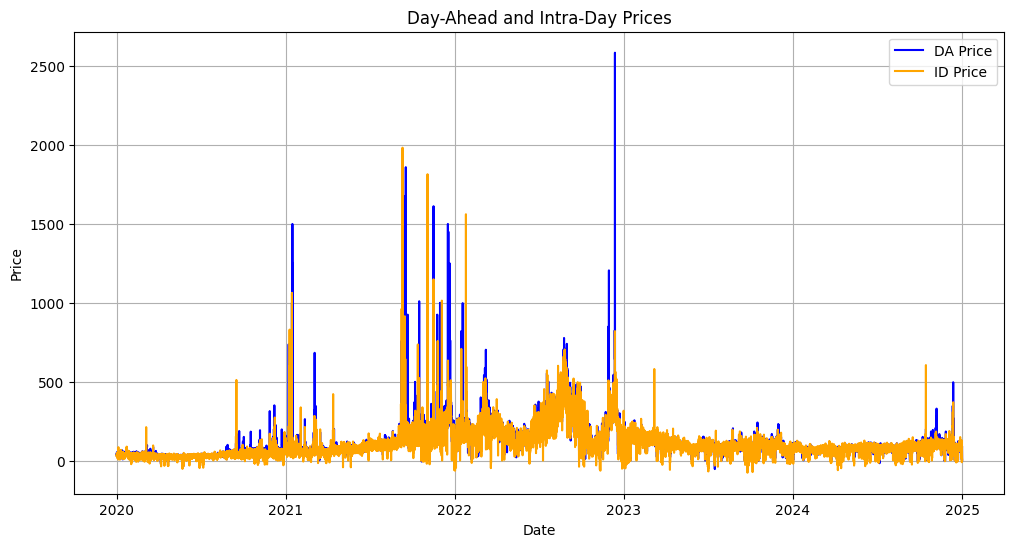

In [118]:
plt.figure(figsize=(12, 6))

plt.plot(df['price_DA'], label='DA Price', color='blue')
plt.plot(df['price_ID'], label='ID Price', color='orange')
plt.title('Day-Ahead and Intra-Day Prices')
#plt.title('Intra-Day Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

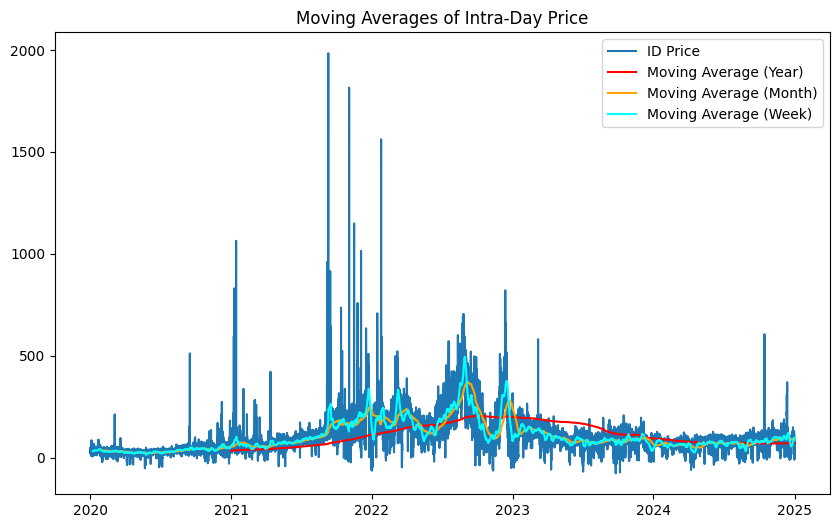

In [119]:
plt.figure(figsize=(10,6))

plt.plot(df['price_ID'], label = 'ID Price')
plt.plot(df['price_ID'].rolling(window=48*365).mean(), label = 'Moving Average (Year)', color = 'red')
plt.plot(df['price_ID'].rolling(window=48*30).mean(), label = 'Moving Average (Month)', color = 'orange')
plt.plot(df['price_ID'].rolling(window=48*7).mean(), label = 'Moving Average (Week)', color = 'cyan')
plt.title("Moving Averages of Intra-Day Price")

plt.legend()
plt.show()

This graph illustrates the evolution of Day-Ahead (DA) and Intra-Day (ID) prices from 2020 to 2024.

First, the prices remain relatively low and exhibit a fairly stable trend in the early years. However, starting in 2021, there is a noticeable increase in volatility, with sharp spikes in the data. Toward the end of 2021 and the beginning of 2022, as well as at the end of 2022, there is a dramatic surge in prices, with some spikes reaching values above 2500. The years 2022 and 2023 show a more stable pricing pattern, although volatility remains present.

The significant spikes at the end of 2022 can largely be attributed to geopolitical factors, particularly the Russia-Ukraine conflict, which had a considerable impact on energy prices: see the European Council infographic.

It is also notable that the Day-Ahead (DA) and Intra-Day (ID) prices follow the same overall trend, even during periods of high volatility. However, ID prices are consistently lower than DA prices, suggesting regular adjustments made 24 hours and 2 hours prior to delivery.



In [120]:
df_sample = df[(df.index >= "2023-07-01") & (df.index < "2023-07-07")]

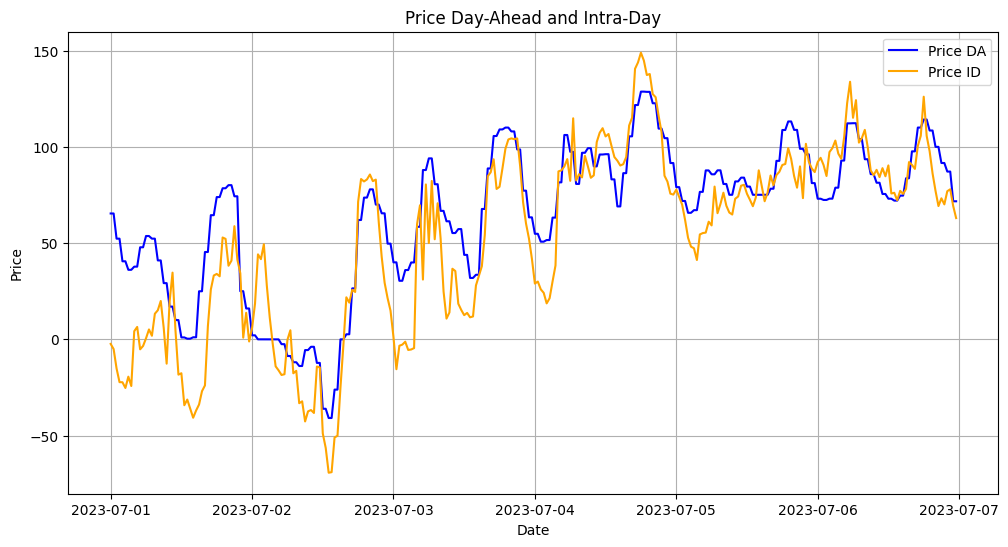

In [121]:
plt.figure(figsize=(12, 6))

plt.plot(df_sample['price_DA'], label='Price DA', color='blue')
plt.plot(df_sample['price_ID'], label='Price ID', color='orange')
plt.title('Price Day-Ahead and Intra-Day')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### A.1.2 Comparative Graph

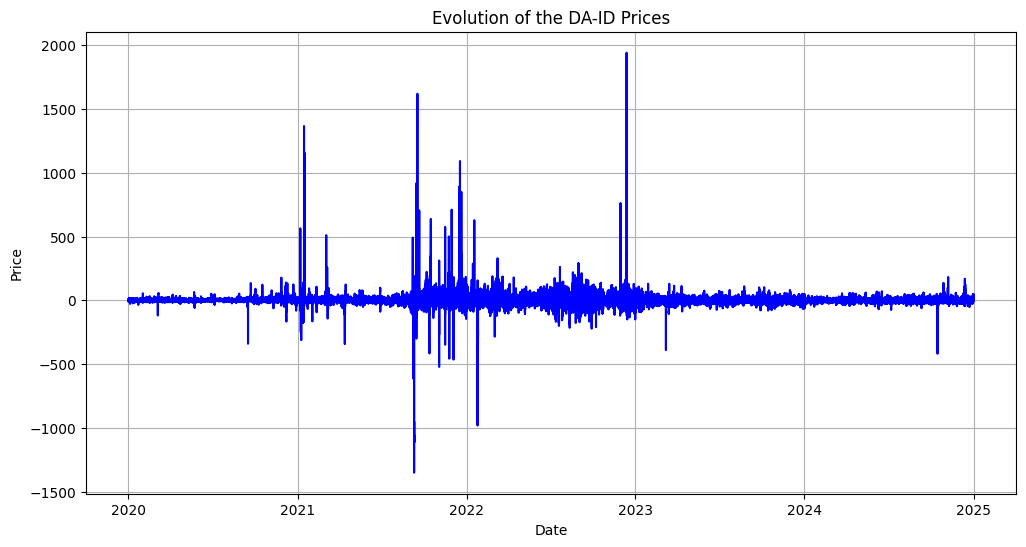

In [122]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['price_DA'] - df['price_ID'], color='blue')
plt.title('Evolution of the DA-ID Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


We note that the DA and ID prices are essentially the same, their difference remains around 0 except during high volatilities, potentially justified previously by a price adjustment

In [123]:
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Hour"] = df.index.hour

### A.1.3 Detection of trends and seasonality

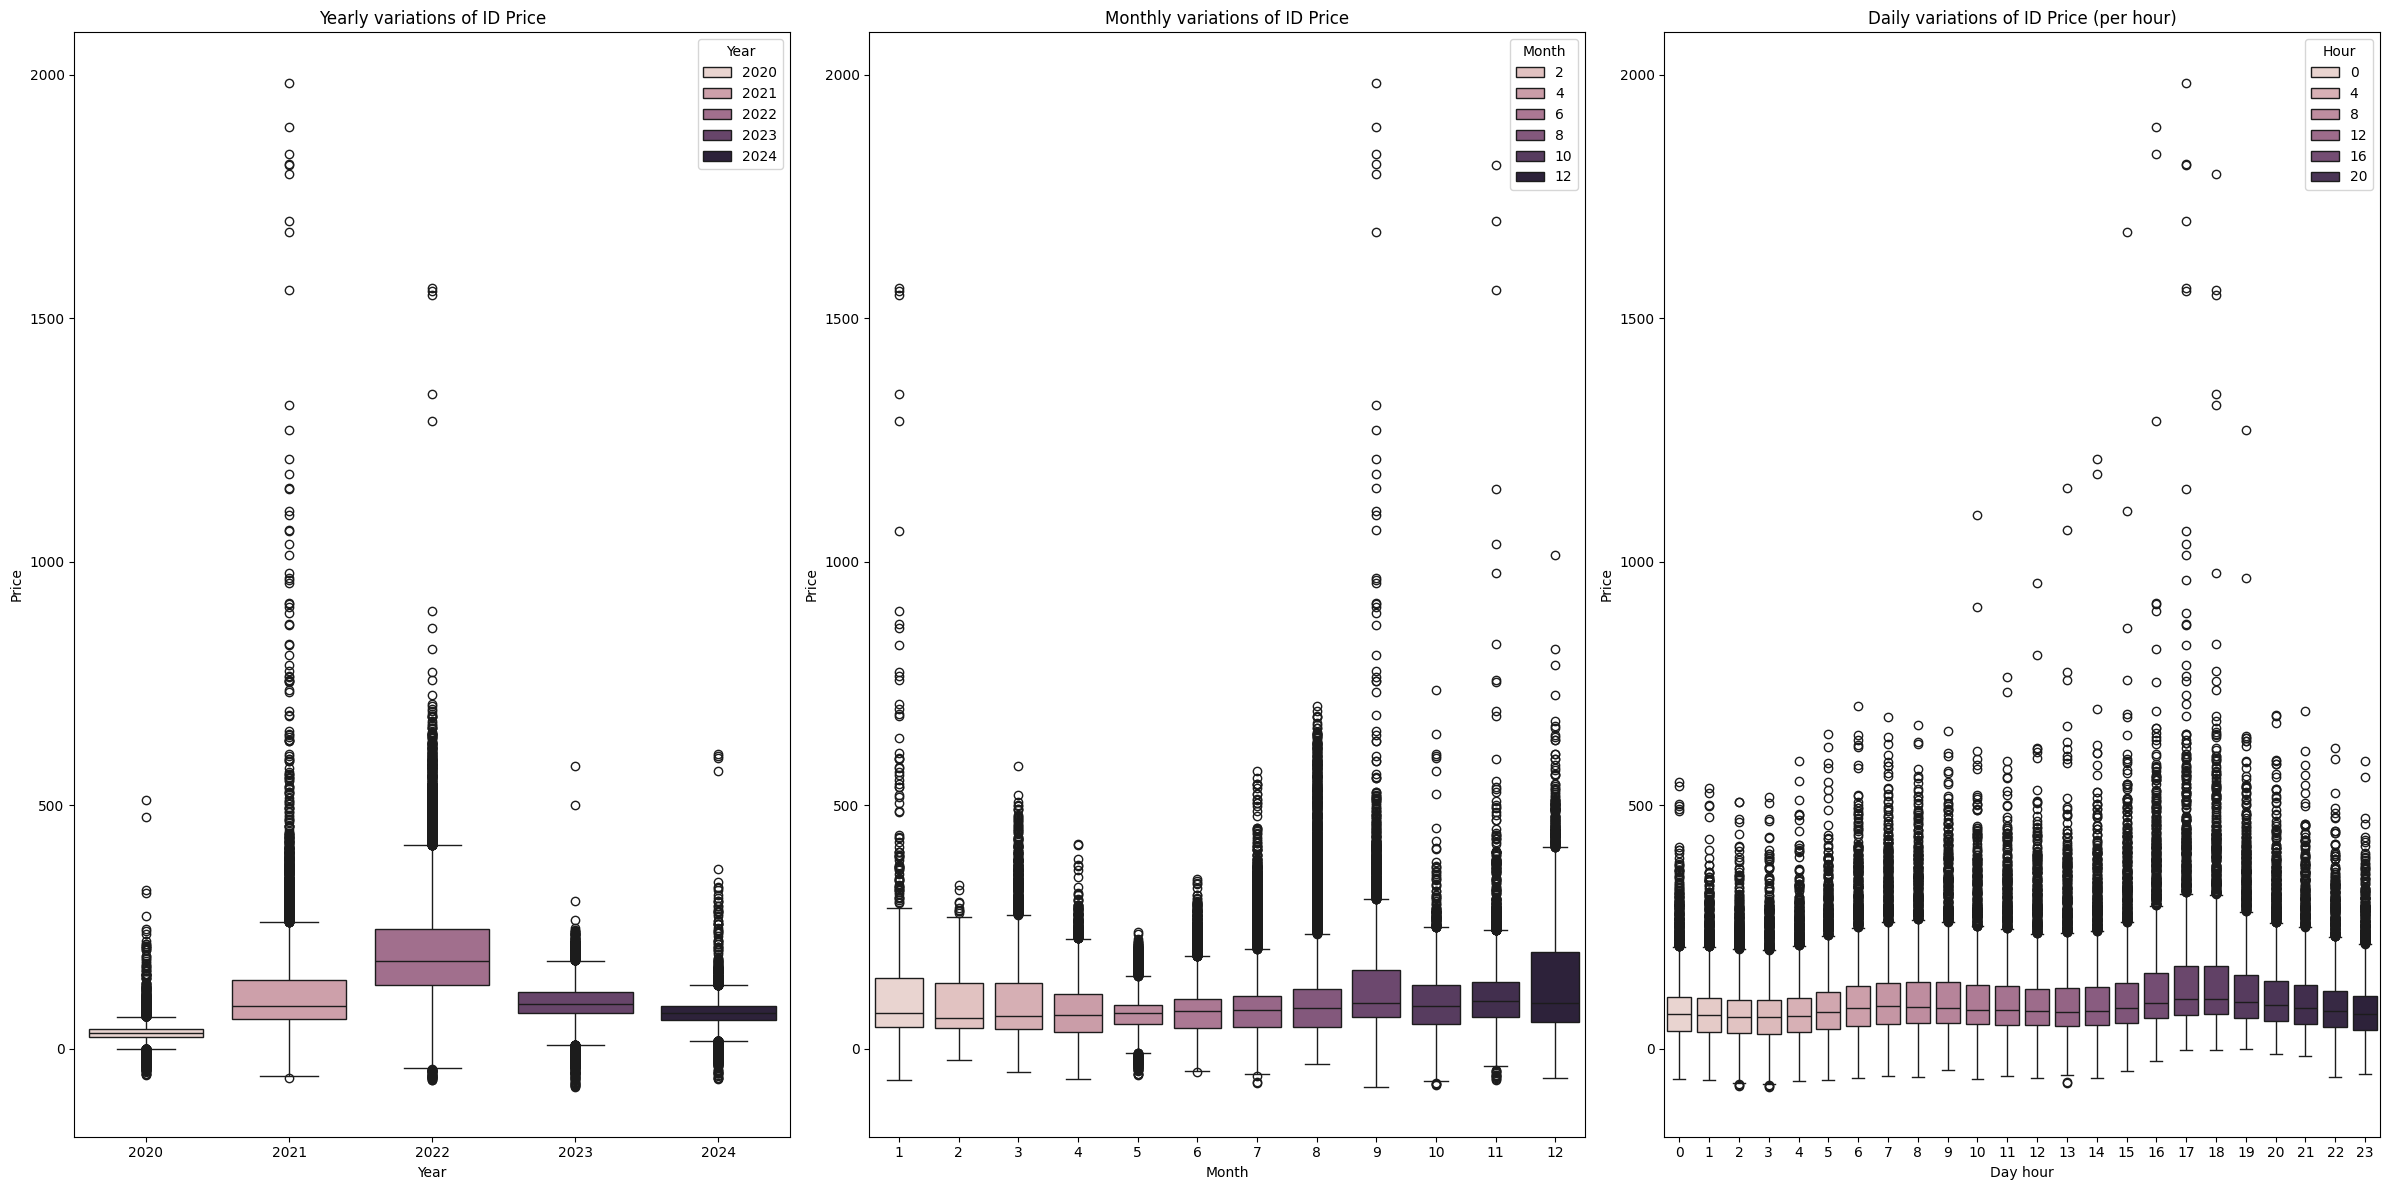

In [98]:
#fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

# Boxplots pour le prix DA
# sns.boxplot(x="Year", y="price_DA", data=df, ax=axes[0, 0], hue='Year')
# axes[0, 0].set_title("Yearly variations of DA Price")
# axes[0, 0].set_xlabel("Year")
# axes[0, 0].set_ylabel("Price")

# sns.boxplot(x="Month", y="price_DA", data=df, ax=axes[0, 1], hue='Month')
# axes[0, 1].set_title("Monthly variations of DA Price")
# axes[0, 1].set_xlabel("Month")
# axes[0, 1].set_ylabel("Price")

# sns.boxplot(x="Hour", y="price_DA", data=df, ax=axes[0, 2], hue='Hour')
# axes[0, 2].set_title("Daily variations of DA Price (per hour)")
# axes[0, 2].set_xlabel("Day hour")
# axes[0, 2].set_ylabel("Price")

# Boxplots pour le prix ID
sns.boxplot(x="Year", y="price_ID", data=df, ax=axes[0], hue='Year')
axes[0].set_title("Yearly variations of ID Price")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Price")

sns.boxplot(x="Month", y="price_ID", data=df, ax=axes[1], hue='Month')
axes[1].set_title("Monthly variations of ID Price")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Price")

sns.boxplot(x="Hour", y="price_ID", data=df, ax=axes[2], hue='Hour')
axes[2].set_title("Daily variations of ID Price (per hour)")
axes[2].set_xlabel("Day hour")
axes[2].set_ylabel("Price")

plt.tight_layout()
plt.show()


**Variations of DA Price**

Prices fluctuate significantly, with 2021 and 2022 showing high volatility.2022 exhibits extreme price spikes.2023 and 2024 have more stable prices with fewer extreme values.

We notice that prices are almost stable on average during the years except 2021 and 2022 which present a much greater volatility. The years 2021 and 2022 concentrate a lot of extreme values ​​although the other years are much more stable with much tighter standard deviations.

Monthly speaking, we notice a change in prices towards the end of the year, especially the months of September November December January, surely explainable by the winter. December and September contain the most volatility.

During the day, the price pick is around 17/18h with greater volatility, although during the day and night, prices are relatively stable.

**Variations of ID Price**

The results are similar.

**Conclusion**

Annual trends: 2021 and 2022 were particularly volatile, while 2023 and 2024 show more stability.

Monthly trends: Prices generally increase in the last months of the year, with evident seasonal trends.

Daily trends: Prices follow a daily cycle, increasing throughout the day and peaking in the evening.

## A.2 Intra-Day Price Description (time series)

### A.2.1 Stationarity analysis

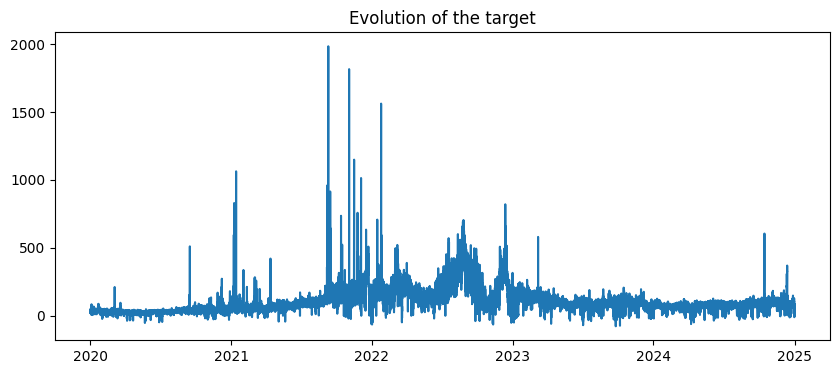

ADF Statistic: -9.29405375924127
p-value: 1.158905264665382e-15
Stationary


In [124]:
target = df['price_ID']

plt.figure(figsize=(10,4))
plt.plot(target, label='Price ID')
plt.title("Evolution of the target")
plt.show()

#Test ADFuller
result = adfuller(target)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("Stationary")
else:
    print("Not stationary")

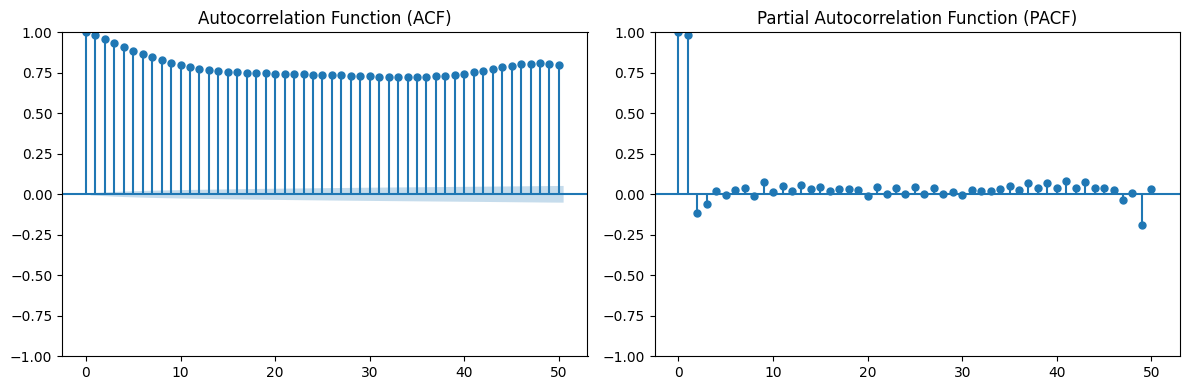

In [125]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_acf(target, lags=50, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1,2,2)
plot_pacf(target, lags=50, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

**The results present a paradox.**

The ADFuller test confirms a stationarity of our model but the Autocorrelation Functions and Partial Autocorrelation Function show the opposite. Indeed, the ACF presents lags that do not tend a slow decay even for large values ​​of lags and presents a seasonality or a trend. highlighting the non-stationary aspect of our target. There is therefore a strong autocorrelation

As for the PACF, it presents a significant peak at lag 1, followed by low or insignificant values.
This model suggests an AR(1) process, which means that the current value of the series depends mainly on its immediate past value.

To ensure stationarity, we will difference our time series

In [126]:
target_diff = df['price_ID'].diff().dropna()  #differenciation for stationarit

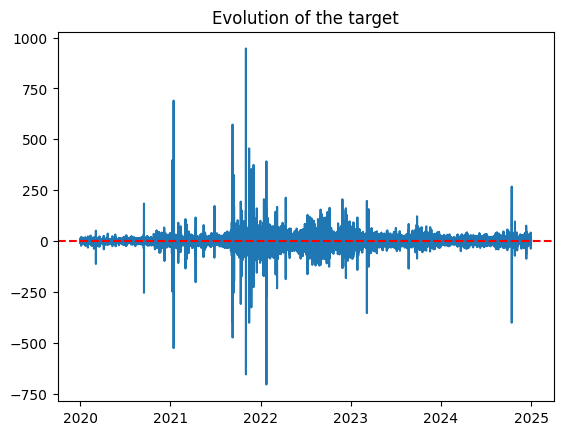

<Figure size 1200x600 with 0 Axes>

ADF Statistic: -49.39116079414405
p-value: 0.0
Stationary


In [127]:
plt.plot(target_diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Evolution of the target")
plt.figure(figsize=(12,6))
plt.show()

result = adfuller(target_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Stationary")
else:
    print("Not stationary")

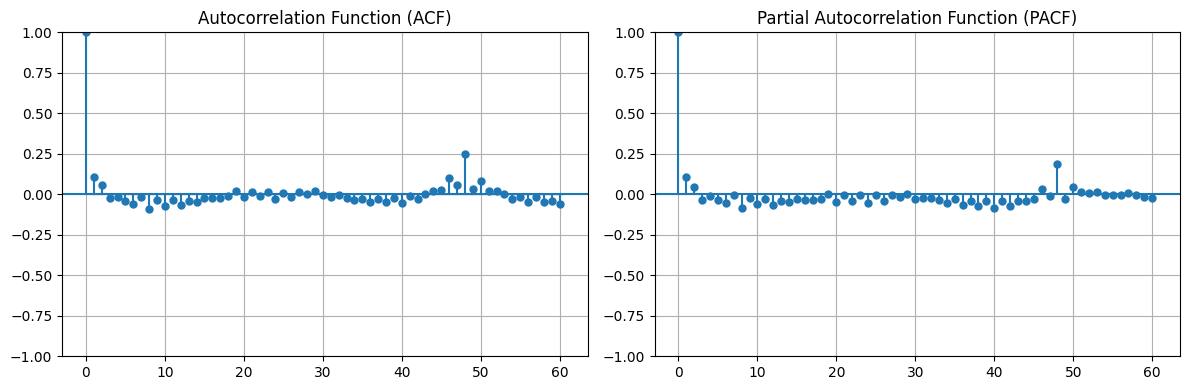

In [128]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_acf(target_diff, lags=60, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")
plt.grid(True)

plt.subplot(1,2,2)
plot_pacf(target_diff, lags=60, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.grid(True)

plt.tight_layout()
plt.show()

The ACF drops sharply after lag 0, meaning that the time series has minimal long-term autocorrelation.
There are small spikes at some lags, but none are strongly significant.
This suggests that the time series is stationary, unlike above where the ACF had a slow decay.

The PACF also drops sharply after lag 0.
No significant lags stand out, except for minor spikes at later lags.
This suggests that there is no strong autoregressive (AR) structure beyond the immediate past value.

In [129]:
#Modification : intraday price every 30 mn -> every hour

df.reset_index(inplace=True)
df['GMT_PERIOD_START_DATETIME'] = pd.to_datetime(df['GMT_PERIOD_START_DATETIME'])
df_filtered = df[df['GMT_PERIOD_START_DATETIME'].dt.minute == 0]

The goal here is to observe how the results change based on their frequency: hourly instead of every 30 minutes. Furthermore, this approach will also enable us to better manage the features, which are already at an hourly frequency.

In [130]:
target_filtered_diff = df_filtered['price_ID'].diff().dropna()

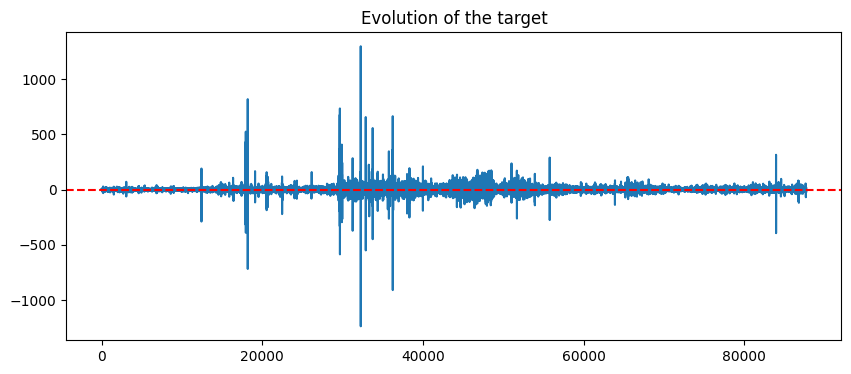

ADF Statistic: -38.855024764882295
p-value: 0.0
Stationary


In [131]:
plt.figure(figsize=(10,4))
plt.plot(target_filtered_diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Evolution of the target")
plt.show()

result = adfuller(target_filtered_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Stationary")
else:
    print("Not Stationary")

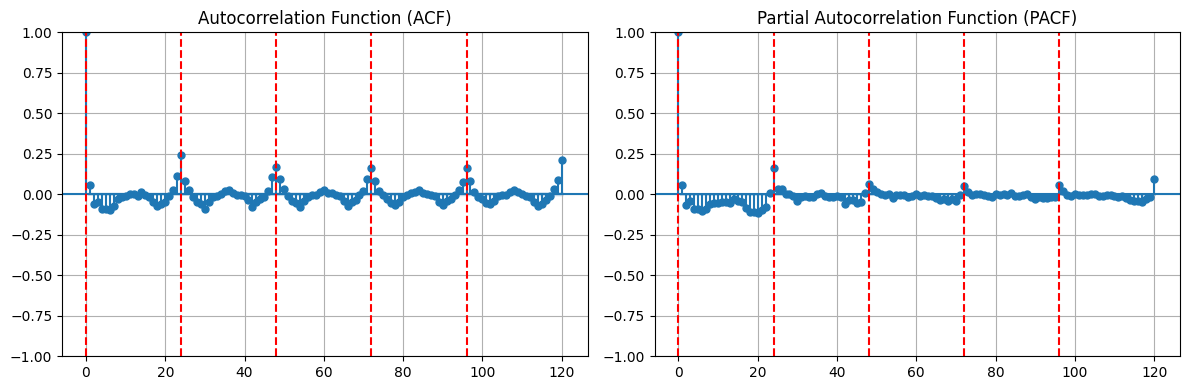

In [132]:
plt.figure(figsize=(12,4))
MAX_LAGS = 120
LIST_SEASONAL = [i for i in range(MAX_LAGS) if i % 24 == 0]

plt.subplot(1,2,1)
plot_acf(target_filtered_diff, lags=MAX_LAGS, ax=plt.gca())

for i in LIST_SEASONAL:
    plt.axvline(x= i, ls = "--", color = 'red' )
plt.title("Autocorrelation Function (ACF)")
plt.grid(True)

plt.subplot(1,2,2)
plot_pacf(target_filtered_diff, lags=MAX_LAGS, ax=plt.gca(), method='ywm')
for i in LIST_SEASONAL:
    plt.axvline(x= i, ls = "--", color = 'red' )
plt.title("Partial Autocorrelation Function (PACF)")
plt.grid(True)

plt.tight_layout()
plt.show()

The repeated pattern in the ACF plot suggests a **seasonal** or **periodic** component in the data, where values ​​at certain lags are highly correlated. This indicates that the data follows a regular cycle (e.g., annual, monthly, etc.). This phenomenon can be due to seasonal effects or long-term trends. A model like **SARIMA** (Seasonal ARIMA) would be suitable to model this type of behavior, as it takes into account seasonal effects and time dependencies at regular intervals.

In [133]:
df_filtered.set_index('GMT_PERIOD_START_DATETIME',inplace=True)
df_filtered = df_filtered.asfreq('h')

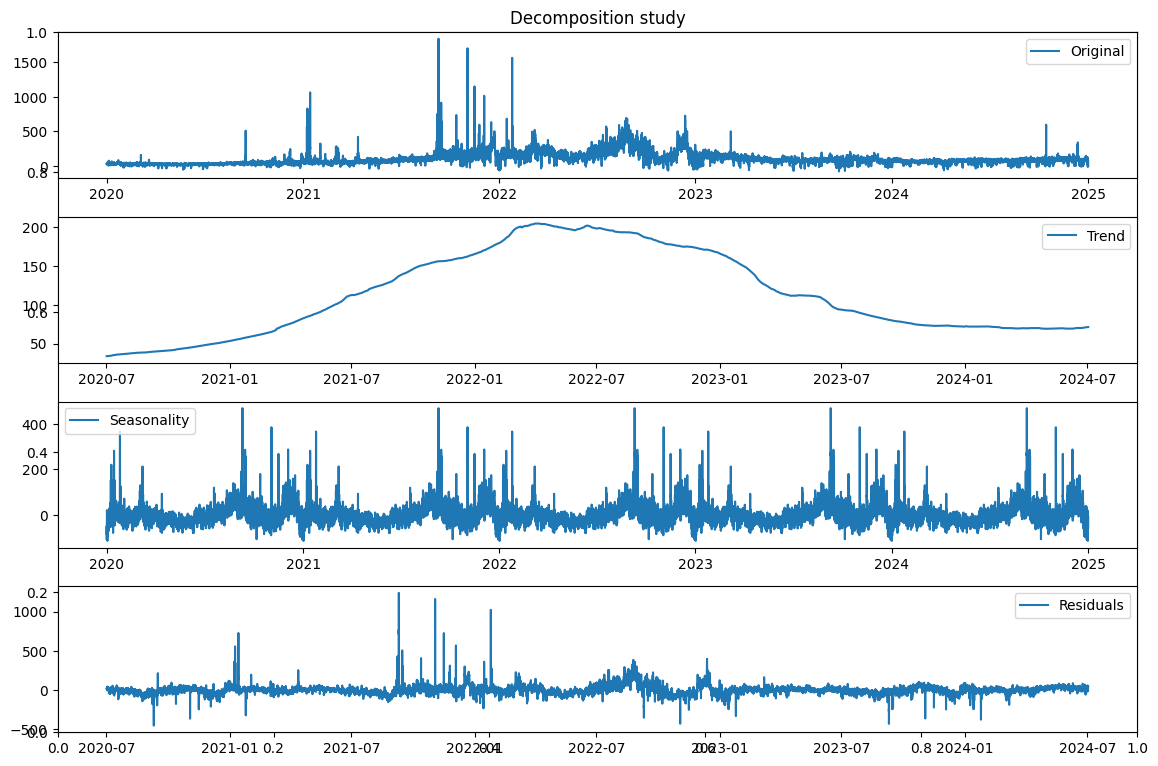

In [134]:
#decomposition = seasonal_decompose(df_filtered['price_ID'], model='additive', period= 24)  #daily
#decomposition = seasonal_decompose(df_filtered['price_ID'], model='additive', period= 24*7) #weekly
decomposition = seasonal_decompose(df_filtered['price_ID'], model='additive', period= 24*365) #annualy


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12, 8))
plt.title("Decomposition study")

plt.subplot(411)
plt.plot(df_filtered['price_ID'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Let's focus only on the last 3

**Trend**:
The trend graph shows a general upward behavior at the beginning of the period and then goes back down. We notice that the peak is reached for the period end of 2021/2022, which is explained with the explanations given above.

**Seasonality**:
The seasonality graph reveals regular variations that repeat at constant intervals, indicating periodic effects. We can then consider seasonal cycles throughout the year.

**Residuals**:
The residuals represent the remaining irregularities. They visibly show a random behavior, without obvious structure, suggesting that no additional trend is present in the price ID.

## A.3 Features selection

In [135]:
df_INDGEN_DA = pd.read_csv("dataset/INDGEN_DA.csv", 
                           index_col = "GMT_PERIOD_START_DATETIME", 
                           parse_dates = True)

df_INDGEN_ID = pd.read_csv("dataset/INDGEN_ID.csv",
                           index_col = "GMT_PERIOD_START_DATETIME", 
                           parse_dates = True)


df_MELNGC_ID = pd.read_csv("dataset/MELNGC_ID.csv",
                           index_col = "GMT_PERIOD_START_DATETIME", 
                           parse_dates = True)

df_MELNGC_DA = pd.read_csv("dataset/MELNGC_DA.csv",
                           index_col = "GMT_PERIOD_START_DATETIME", 
                           parse_dates = True)


df_TSDF_ID = pd.read_csv("dataset/TSDF_ID.csv",
                         index_col = "GMT_PERIOD_START_DATETIME", 
                         parse_dates = True)

df_TSDF_DA = pd.read_csv("dataset/TSDF_DA.csv",
                         index_col = "GMT_PERIOD_START_DATETIME", 
                         parse_dates = True)

In [136]:
df_INDGEN_DA = df_INDGEN_DA.dropna()
df_INDGEN_ID = df_INDGEN_ID.dropna()

df_MELNGC_ID = df_MELNGC_ID.dropna()
df_MELNGC_DA = df_MELNGC_DA.dropna()

df_TSDF_ID = df_TSDF_ID.dropna()
df_TSDF_DA = df_TSDF_DA.dropna()

In [137]:
FEATURES = [df_INDGEN_DA, df_INDGEN_ID, df_MELNGC_ID, df_MELNGC_DA, df_TSDF_ID, df_TSDF_DA ]

for feature in FEATURES:
    feature['Total (in MW)'] = feature.iloc[:,1:].sum(axis = 1)
    feature = feature.reset_index(inplace=True)

In [138]:
df_corr = df_filtered.merge(df_INDGEN_DA[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                            on='GMT_PERIOD_START_DATETIME', 
                            how = 'inner')

df_corr = df_corr.rename(columns = {'Total (in MW)':'TOTAL_INDGEN_DA (in MW)' })


df_corr = df_corr.merge(df_INDGEN_ID[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                        on='GMT_PERIOD_START_DATETIME', 
                        how = 'inner')

df_corr = df_corr.rename(columns = {'Total (in MW)':'TOTAL_INDGEN_ID (in MW)' })


df_corr = df_corr.merge(df_MELNGC_ID[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                        on='GMT_PERIOD_START_DATETIME', 
                        how = 'inner')

df_corr = df_corr.rename(columns = {'Total (in MW)':'TOTAL_MELNGC_ID (in MW)' })


df_corr = df_corr.merge(df_MELNGC_DA[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                        on='GMT_PERIOD_START_DATETIME', 
                        how = 'inner')

df_corr = df_corr.rename(columns = {'Total (in MW)':'TOTAL_MELNGC_DA (in MW)' })


df_corr = df_corr.merge(df_TSDF_ID[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                        on='GMT_PERIOD_START_DATETIME', 
                        how = 'inner')

df_corr = df_corr.rename(columns = {'Total (in MW)':'TOTAL_TSDF_ID (in MW)' })



df_corr = df_corr.merge(df_TSDF_DA[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                        on='GMT_PERIOD_START_DATETIME', 
                        how = 'inner')

df_corr = df_corr.rename(columns = {'Total (in MW)':'TOTAL_TSDF_DA (in MW)' })

In [139]:
df_corr = df_corr.drop(columns=['GMT_PERIOD_START_DATETIME','Year','Month','Hour'])

### A.3.1 Correlation Matrix

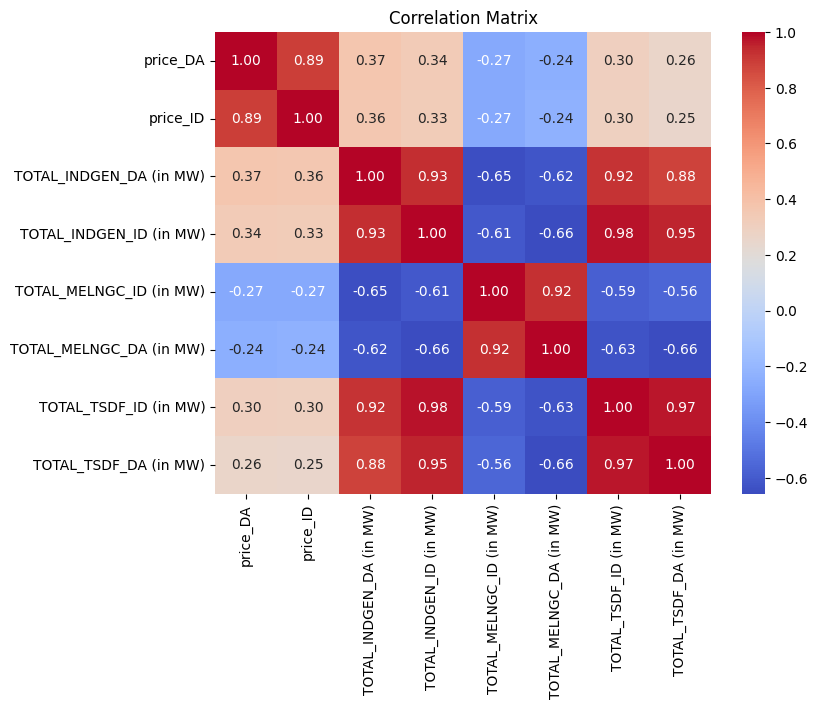

In [140]:
plt.figure(figsize=(8,6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

I chose to keep the **`price_DA`**, **`TOTAL_INDGEN_ID (in MW)`**, and **`TOTAL_MELNGC_ID (in MW)`** variables to predict **`price_ID`**, due to their respective relevance.

**`price_DA`** has a strong positive correlation with **`price_ID` (0.89)**, making it an important feature to predict the target.

**`TOTAL_INDGEN_ID (in MW)`** has a moderate correlation (0.34), suggesting that it provides useful additional information on energy production trends. Finally, although **`TOTAL_MELNGC_ID (in MW)`** has a weak and negative correlation (-0.27) with **`price_ID`**, I chose to keep it because it could reflect effects not captured by the other variables.

These three features seem to provide important complementary information.

# B. Models

## B.1 Features Engineering

### B.1.1 Handling missing values

Missing values ​​will be handled by interpolation. Indeed, the SARIMAX model does not support missing values. Representing around 3% or even less of the total values ​​of their column in question, it is preferable to interpolate them. The choice fell on two methods: spline of order 5 and linear. The choice was made after testing several different methods and after visualizing graphically.

In [141]:
df_INDGEN_ID = pd.read_csv("dataset/INDGEN_ID.csv",
                           index_col = "GMT_PERIOD_START_DATETIME", 
                           parse_dates = True) # No missing values

df_MELNGC_ID = pd.read_csv("dataset/MELNGC_ID.csv",
                           index_col = "GMT_PERIOD_START_DATETIME", 
                           parse_dates = True) #1333 values missing

df = pd.read_csv("dataset/prices.csv") #56 missing values for DA price

In [142]:
df['GMT_PERIOD_START_DATETIME'] = pd.to_datetime(df['GMT_PERIOD_START_DATETIME'])
df_filtered = df[df['GMT_PERIOD_START_DATETIME'].dt.minute == 0]

In [143]:
features = [df_INDGEN_ID, df_MELNGC_ID]

for feature in features:
    feature['Total (in MW)'] = feature.iloc[:,1:].sum(axis = 1,skipna=False)
    feature = feature.reset_index(inplace=True)

In [144]:
df_exo = df_filtered.copy()

df_exo = df_exo.merge(df_INDGEN_ID[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                      on='GMT_PERIOD_START_DATETIME',
                      how='outer')

df_exo = df_exo.rename(columns={'Total (in MW)':'TOTAL_INDGEN_ID (in MW)'})

df_exo = df_exo.merge(df_MELNGC_ID[['GMT_PERIOD_START_DATETIME', 'Total (in MW)']], 
                      on='GMT_PERIOD_START_DATETIME',
                      how='outer')

df_exo = df_exo.rename(columns={'Total (in MW)':'TOTAL_MELNGC_ID (in MW)'})

In [145]:
df_exo.set_index('GMT_PERIOD_START_DATETIME', inplace=True)

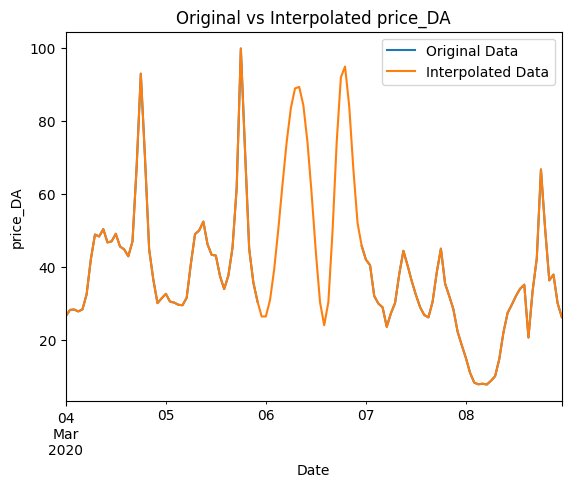

In [146]:
df_exo[(df_exo.index >= '2020-03-04 00:00:00') & (df_exo.index <= '2020-03-08 23:00:00')]['price_DA'].plot(label='Original Data') #subset of missing values

df_exo['price_DA'] = df_exo['price_DA'].interpolate(method='spline', order=5)

df_exo[(df_exo.index >= '2020-03-04 00:00:00') & (df_exo.index <= '2020-03-08 23:00:00')]['price_DA'].plot(label='Interpolated Data')

plt.legend()
plt.title('Original vs Interpolated price_DA')
plt.xlabel('Date')
plt.ylabel('price_DA')
plt.show()


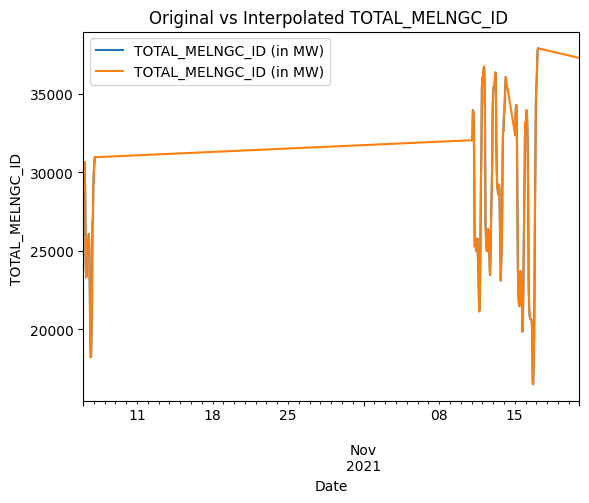

In [147]:
df_exo[(df_exo.index >= '2021-10-06 00:00:00') & (df_exo.index <='2021-11-20 23:00:00')]['TOTAL_MELNGC_ID (in MW)'].plot() #subset of missing values

df_exo['TOTAL_MELNGC_ID (in MW)'] = df_exo['TOTAL_MELNGC_ID (in MW)'].interpolate(method='linear')

df_exo[(df_exo.index >= '2021-10-06 00:00:00') & (df_exo.index <='2021-11-20 23:00:00')]['TOTAL_MELNGC_ID (in MW)'].plot()

plt.legend()
plt.title('Original vs Interpolated TOTAL_MELNGC_ID ')
plt.xlabel('Date')
plt.ylabel('TOTAL_MELNGC_ID ')
plt.show()


## B.2 SARIMAX Model

<h3 style="text-align: center;"> ARIMA Model </h3>

Le modèle ARIMA is a powerful statistical technique for modeling and forecasting time series. It is based on three key components: autoregression (AR), moving average (MA) and integration (I).

Autoregression (AR) consists of performing a linear regression on the last p values of the time series in order to predict the current value:
$$
 X_{t} = \epsilon_t + \phi X_{t-1} + ... + \phi_q X_{t-q}
$$
It is characterized by an order generally noted p.

The moving average (MA) consists of performing a linear regression on the last q error values in order to predict the current value:

$$
 X_{t} = \epsilon_t + \theta \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}
$$

It is characterized by an order generally noted q.

Integration (I) is used to make the time series stationary, by differentiating the values to facilitate modeling. It is characterized by the number of differenciations generally noted q.

<h3 style="text-align: center;"> SARIMAX Model </h3>

The SARIMAX model retains the key components of the ARIMA model while introducing two major elements: the seasonal (S) and the covariates component (X).

**Autoregression (AR)**: As before, autoregression examines past values of the time series to predict current values.

**Moving average (MA)**: The moving average continues to model past errors in predictions.

**Integration (I)**: Integration is always present to make the time series stationary.

**Seasonal component (S)**: The seasonal component captures variations that recur at regular intervals.

**Covariates (X)**: Covariates are external variables that can influence the time series.

Source : *https://datascientest.com/en/sarimax-model-what-is-it-how-can-it-be-applied-to-time-series*



The SARIMAX model is a good candidate for the exercise. Our study above does indeed present a seasonality present in the data below. In addition, the features chosen previously can be a good tool for optimizing our forecasting model.

In [148]:
df_exo

,price_DA,price_ID,TOTAL_INDGEN_ID (in MW),TOTAL_MELNGC_ID (in MW)
GMT_PERIOD_START_DATETIME,,,,
2020-01-01 00:00:00,43.45,35.28,25632.0,34590.0
2020-01-01 01:00:00,41.12,37.78,25321.0,34046.0
2020-01-01 02:00:00,29.98,31.70,24255.0,35489.0
2020-01-01 03:00:00,27.10,28.97,23181.5,36906.5
2020-01-01 04:00:00,26.37,31.40,22107.0,37885.0
...,...,...,...,...
2024-12-31 19:00:00,55.68,47.41,28749.0,33998.0
2024-12-31 20:00:00,40.00,28.53,28034.0,34826.0
2024-12-31 21:00:00,27.71,15.98,27287.0,35461.5


After a previous study, the SARIMAX model remains very sensitive to outliers. Faced with our very volatile dataset, the choice of outlier management was necessary. I therefore opted for the use of the InterQuantile IQR

In [149]:
df_exo_SARIMAX = df_exo.copy()

q75 = df_exo_SARIMAX['price_ID'].quantile(.75)
q25 = df_exo_SARIMAX['price_ID'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaces by that value
tol = 3
df_exo_SARIMAX['price_ID'] = df_exo_SARIMAX['price_ID'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
df_exo_SARIMAX['price_ID'] = df_exo_SARIMAX['price_ID'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)

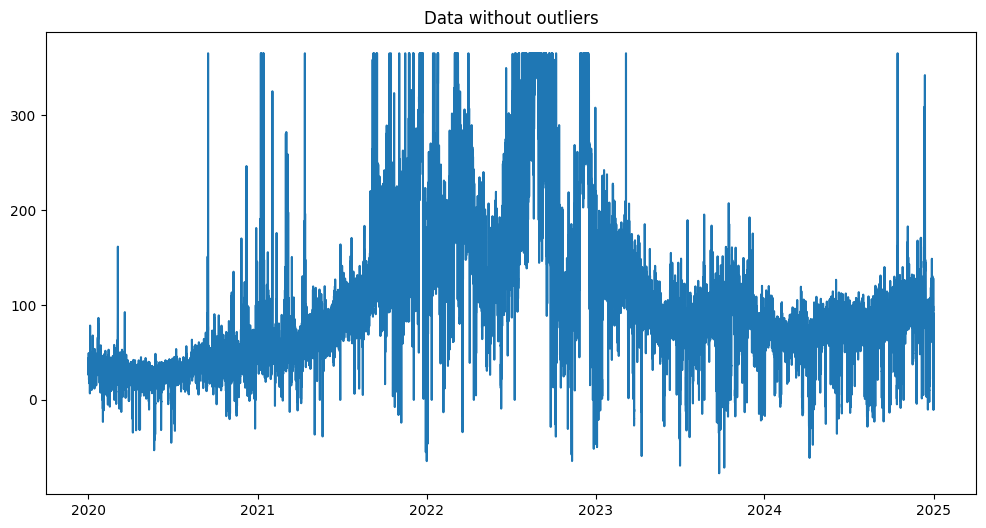

In [150]:
plt.figure(figsize=(12,6))
plt.plot(df_exo_SARIMAX.index, df_exo_SARIMAX['price_ID'])
plt.title("Data without outliers")
plt.show()

In [151]:
train_data = df_exo_SARIMAX.loc['2020-01-01':'2023-12-31'] #75%
test_data = df_exo_SARIMAX.loc['2024-01-01':'2024-12-31'] # 25%

In [152]:
train_data.isna().sum()

price_DA                   0
price_ID                   0
TOTAL_INDGEN_ID (in MW)    0
TOTAL_MELNGC_ID (in MW)    0
dtype: int64

### B.2.1 Prediction

The selection of parameters was made based on the results obtained above, along with manual trials aiming to achieve the lowest possible AIC. Additionally, a specialized parameter optimization tool for ARIMA, **`pm.auto_arima()`**, was used, but my computer lacks the necessary resources to run it.

In [153]:
model = SARIMAX(train_data['price_ID'], 
                order=(1,1,0),  
                seasonal_order=(1,1,1,24),
                exog=train_data[['price_DA',
                                'TOTAL_INDGEN_ID (in MW)',
                                'TOTAL_MELNGC_ID (in MW)']]) 
result = model.fit()

print(result.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34235D+00    |proj g|=  8.60845D-01

At iterate    5    f=  4.34182D+00    |proj g|=  5.15267D-01

At iterate   10    f=  4.33440D+00    |proj g|=  1.36231D+00

At iterate   15    f=  4.33182D+00    |proj g|=  1.08896D+00

At iterate   20    f=  4.33070D+00    |proj g|=  1.83235D-01

At iterate   25    f=  4.32775D+00    |proj g|=  1.76868D+00

At iterate   30    f=  4.29912D+00    |proj g|=  6.48325D-01

At iterate   35    f=  4.29681D+00    |proj g|=  3.39307D-01

At iterate   40    f=  4.27649D+00    |proj g|=  4.50969D-01

At iterate   45    f=  4.25811D+00    |proj g|=  1.17653D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Ca

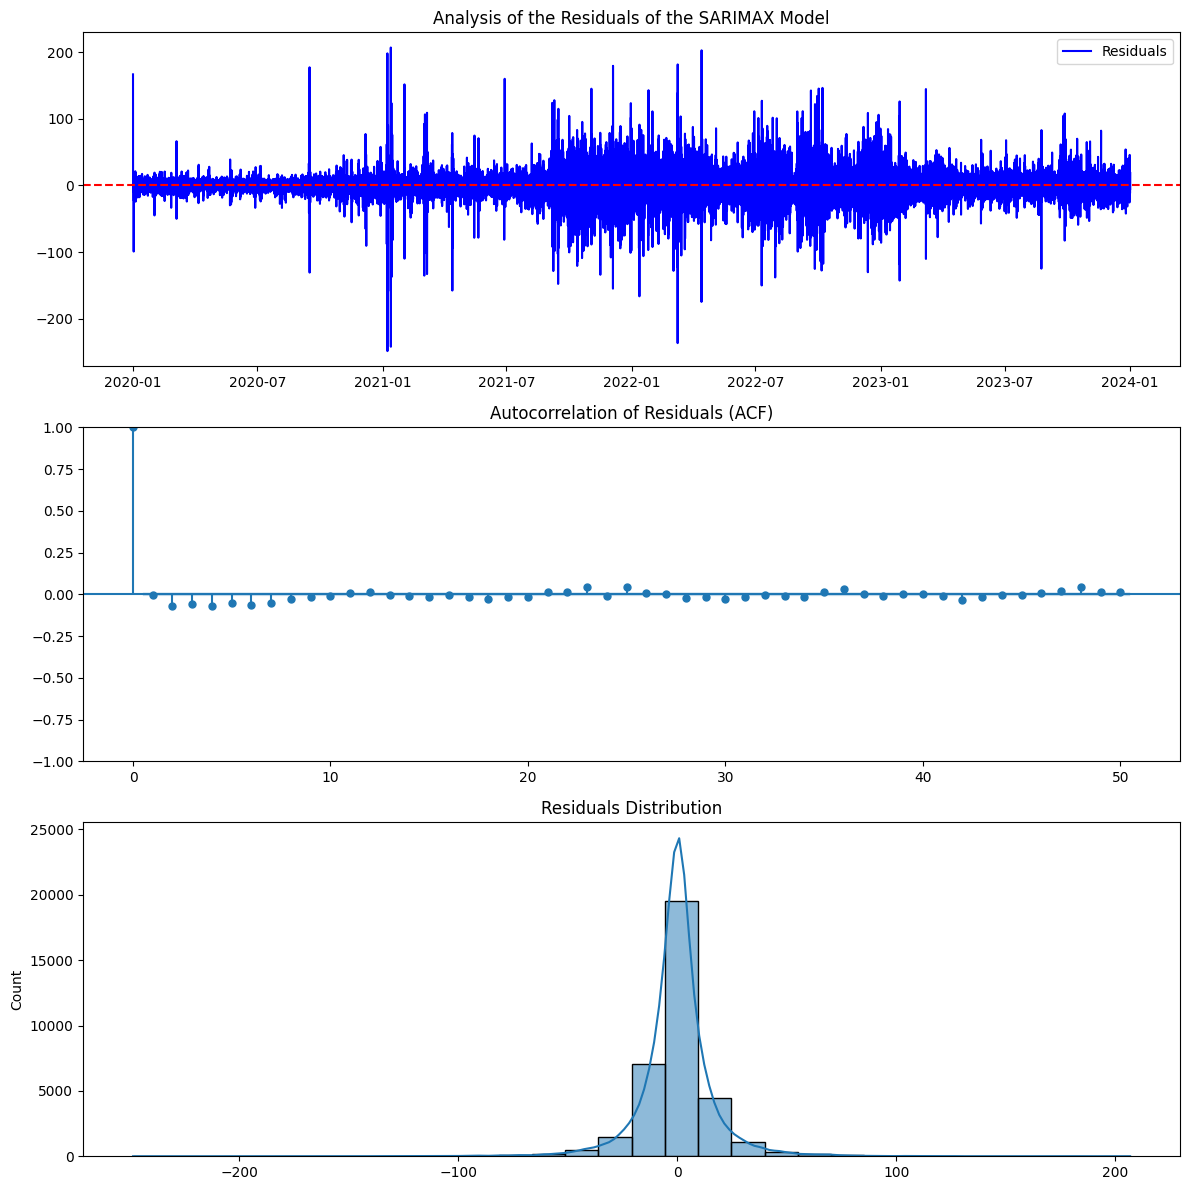

In [154]:
residuals = result.resid 

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
axes[0].plot(residuals, label="Residuals", color="blue")
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title("Analysis of the Residuals of the SARIMAX Model")
axes[0].legend()

plot_acf(residuals.dropna(), lags=50, ax=axes[1])
axes[1].set_title("Autocorrelation of Residuals (ACF)")

sns.histplot(residuals.dropna(), kde=True, bins=30, ax=axes[2])
axes[2].set_title("Residuals Distribution")

plt.tight_layout()
plt.show()


Here, the residuals are now more evenly distributed around zero, with minimal autocorrelation and a distribution that closely resembles normality. This suggests that SARIMAX is performing good especially regarding extreme events. However, it still remains some prediction issues.

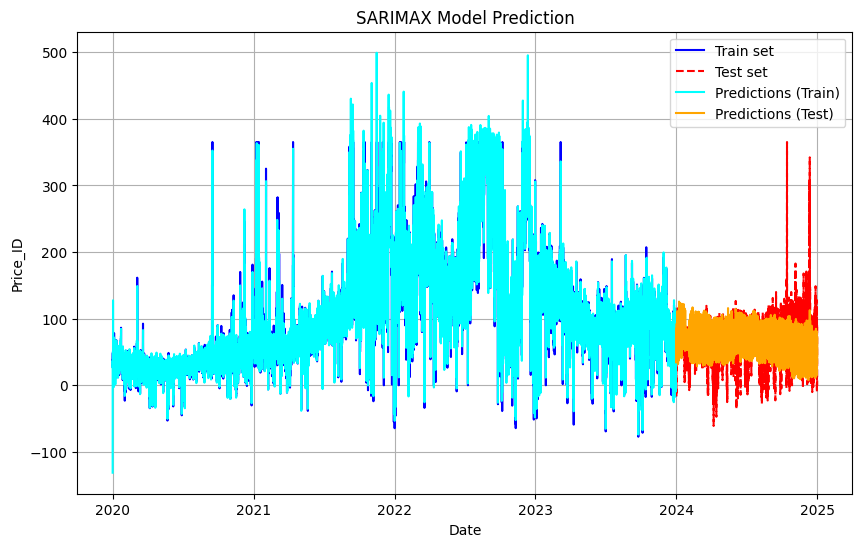

In [155]:
train_predictions = result.predict(start=train_data.index[0], 
                                end=train_data.index[-1],
                                exog=train_data[['price_DA',
                                'TOTAL_INDGEN_ID (in MW)',
                                'TOTAL_MELNGC_ID (in MW)']])


test_predictions = result.predict(start=test_data.index[0], 
                                  end=test_data.index[-1],
                                  exog=test_data[['price_DA',
                                'TOTAL_INDGEN_ID (in MW)',
                                'TOTAL_MELNGC_ID (in MW)']])


plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['price_ID'], label='Train set', color='blue')
plt.plot(test_data.index, test_data['price_ID'], label='Test set', color='red', linestyle='--')
plt.plot(train_predictions.index, train_predictions, label='Predictions (Train)', color='cyan')
plt.plot(test_predictions.index, test_predictions, label='Predictions (Test)', color='orange')


plt.xlabel('Date')
plt.ylabel('Price_ID')
plt.title('SARIMAX Model Prediction')
plt.legend()
plt.grid()
plt.show()

In [74]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcul du RMSE sur l'ensemble d'entraînement
rmse_train = np.sqrt(mean_squared_error(train_data['price_ID'], result.fittedvalues))
print("RMSE sur l'ensemble d'entraînement :", rmse_train)


RMSE sur l'ensemble d'entraînement : 17.150952533509834


In [75]:
# Supposons que test_data contient 'price_ID' et les mêmes variables exogènes
forecast = result.predict(start=test_data.index[0], end=test_data.index[-1],
                          exog=test_data[['price_DA', 'TOTAL_INDGEN_ID (in MW)', 'TOTAL_MELNGC_ID (in MW)']])

rmse_test = np.sqrt(mean_squared_error(test_data['price_ID'], forecast))
print("RMSE sur l'ensemble de test :", rmse_test)


RMSE sur l'ensemble de test : 32.61961144454735


The model appears to have difficulty capturing some spikes or variations in the data, which is visible by the difference between the predictions and the actual test periods.

Overall, it appears to capture the broad trends and changes in Intra Day Prices well.

The test predictions (in red) show that the model fails to accurately reproduce the variations in the actual data, especially for future periods beyond 2024.

### B.2.3 Forecasting

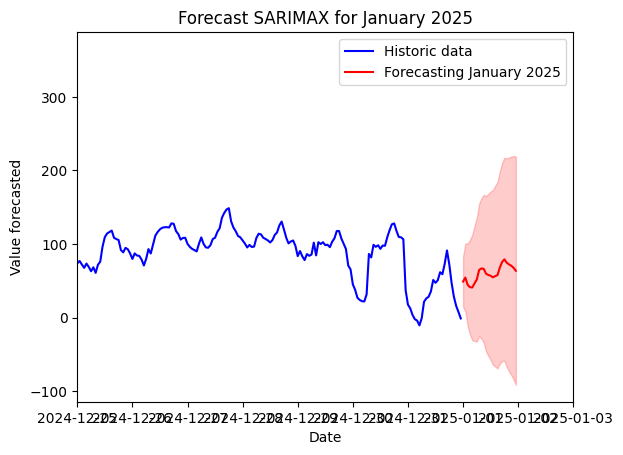

In [ ]:
future_dates = pd.date_range(start="2025-01-01", 
                             periods=24, 
                             freq="h")

forecast = result.get_forecast(steps=24,exog = df_exo[['price_DA',
                                'TOTAL_INDGEN_ID (in MW)',
                                'TOTAL_MELNGC_ID (in MW)']][:24])

forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

forecast_conf
plt.figure(figsize = (12,6))
plt.plot(test_data.index, test_data['price_ID'], label="Historic data", color='blue')
plt.plot(future_dates, forecast_mean, label="Forecasting January 2025", color='red')
plt.fill_between(future_dates, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)

plt.xlabel("Date")
plt.ylabel("Value forecasted")
plt.title("Forecast SARIMAX for January 2025") 
plt.xlim(pd.to_datetime("2024-12-25"), pd.to_datetime("2025-01-3"))
plt.legend()
plt.show()

The historical data shows some volatility and trend, which is captured by SARIMAX.

The forecast for January 2025 shows a trend, but there is some uncertainty in the forecast, as indicated by the confidence range.
The shape of the confidence range shows that while the overall trend is clear, there could be fluctuations that make the forecast less certain as time goes on.

## B.3 XGBoost Model

The XGBoost algorithm (eXtreme Gradient Boosting) is a machine learning model inspired by the concept of Gradient Boosting.

Introduced by Friedman in 2001, Gradient Boosting is an iterative method where each new model is constructed to minimize the residual errors of the previous models by focusing on the negative gradient of the loss function. This sequential approach results in a more powerful predictive model by combining the strengths of multiple simple models.

Formally, this Gradient Boosting seeks to minimize the loss function by adding weak learners step by step: 
$$
F(x) = \sum_{m=1}^{M} \alpha_m h_{m}(x)
$$

Where $h_{m}(x)$ represents the weak model and αm is the weight assigned to the weak model.

**Source** : *Jerome H. Friedman. “Greedy function approximation: A gradient boosting machine.” In: The Annals of Statistics 29.5 (2001), pp. 1189–1232. doi: 10.1214/aos/1013203451. url: https://doi.org/10.1214/aos/1013203451*

The choice of a Machine Learning model can be valuable as they are capable of capturing complex and nonlinear trends. The XGBoost model is particularly useful due to its Gradient Boosting nature, but also because it handles missing values in the training data effectively, which simplifies the manual handling of these values.

In [100]:
df_exo.index = pd.to_datetime(df_exo.index)

We add these data into the features to give more weight to the temporality of the data, so that it becomes a more important factor and is properly considered.

In [101]:
df_exo["Year"] = df_exo.index.year
df_exo["Month"] = df_exo.index.month
df_exo["Hour"] = df_exo.index.hour
df_exo['Day'] = df_exo.index.day

In [102]:
train_data = df_exo.loc['2020-01-01':'2023-12-31'] #75%
test_data = df_exo.loc['2024-01-01':'2024-12-31'] #25%

In [103]:
features = ['price_DA', 
            'TOTAL_INDGEN_ID (in MW)', 
            'TOTAL_MELNGC_ID (in MW)',
            "Year",
            "Month",
            "Day",
            "Hour"]

X_train = train_data[features]
y_train = train_data['price_ID']

X_test = test_data[features]
y_test = test_data['price_ID']

### B.3.1 GridSearchCV Optimization

Grid Search is a hyperparameter optimization technique for prediction models. Its goal is to find the best combinations of hyperparameters to achieve optimal model performance.

The Grid Search process follows these steps: First, a grid of hyperparameters is defined, specifying potential values for each hyperparameter. A grid is then created by combining all possible value combinations. For each combination in the grid, the model is trained with these parameters on the training set and evaluated on the validation set using a chosen performance metric. All combinations are assessed, and the best hyperparameters are selected based on the performance on the validation set. Finally, the chosen hyperparameters are tested on a separate test set, not used during the tuning process, to provide a final evaluation of the model's performance with the optimized hyperparameters.

In [104]:
param_grid = {
    'n_estimators': [100, 500, 1000],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 5, 7, 9]

}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             random_state=42)

grid_search = GridSearchCV(
                                estimator=xgb_model,
                                param_grid=param_grid,
                                scoring='neg_mean_squared_error',
                                cv=5, 
                                verbose=2,
                                n_jobs=-1)


grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [105]:
best_mse = grid_search.best_score_
best_rmse = np.sqrt(-best_mse)
print(f"Best RMSE: {best_rmse:.4f}")

Best RMSE: 40.7408


In [106]:
grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

### B.3.2 Prediction

In [107]:
model = xgb.XGBRegressor(

    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True)

predictions = model.predict(X_test)

[0]	validation_0-rmse:89.98552	validation_1-rmse:47.25039
[1]	validation_0-rmse:86.41891	validation_1-rmse:45.28288
[2]	validation_0-rmse:83.04903	validation_1-rmse:43.45020
[3]	validation_0-rmse:79.89145	validation_1-rmse:41.70761
[4]	validation_0-rmse:76.90759	validation_1-rmse:40.07886
[5]	validation_0-rmse:74.10451	validation_1-rmse:38.53855
[6]	validation_0-rmse:71.48470	validation_1-rmse:37.05473
[7]	validation_0-rmse:69.02012	validation_1-rmse:35.67713
[8]	validation_0-rmse:66.71613	validation_1-rmse:34.33716
[9]	validation_0-rmse:64.54225	validation_1-rmse:33.13323
[10]	validation_0-rmse:62.51345	validation_1-rmse:32.00449
[11]	validation_0-rmse:60.62396	validation_1-rmse:30.88817
[12]	validation_0-rmse:58.85653	validation_1-rmse:29.88707
[13]	validation_0-rmse:57.20296	validation_1-rmse:28.96195
[14]	validation_0-rmse:55.67354	validation_1-rmse:28.03575
[15]	validation_0-rmse:54.24745	validation_1-rmse:27.20038
[16]	validation_0-rmse:52.92044	validation_1-rmse:26.44122
[17]	va

In [110]:
result_xg = model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True)

[0]	validation_0-rmse:89.98552	validation_1-rmse:47.25039
[1]	validation_0-rmse:86.41891	validation_1-rmse:45.28288
[2]	validation_0-rmse:83.04903	validation_1-rmse:43.45020
[3]	validation_0-rmse:79.89145	validation_1-rmse:41.70761
[4]	validation_0-rmse:76.90759	validation_1-rmse:40.07886
[5]	validation_0-rmse:74.10451	validation_1-rmse:38.53855
[6]	validation_0-rmse:71.48470	validation_1-rmse:37.05473
[7]	validation_0-rmse:69.02012	validation_1-rmse:35.67713
[8]	validation_0-rmse:66.71613	validation_1-rmse:34.33716
[9]	validation_0-rmse:64.54225	validation_1-rmse:33.13323
[10]	validation_0-rmse:62.51345	validation_1-rmse:32.00449
[11]	validation_0-rmse:60.62396	validation_1-rmse:30.88817
[12]	validation_0-rmse:58.85653	validation_1-rmse:29.88707
[13]	validation_0-rmse:57.20296	validation_1-rmse:28.96195
[14]	validation_0-rmse:55.67354	validation_1-rmse:28.03575
[15]	validation_0-rmse:54.24745	validation_1-rmse:27.20038
[16]	validation_0-rmse:52.92044	validation_1-rmse:26.44122
[17]	va

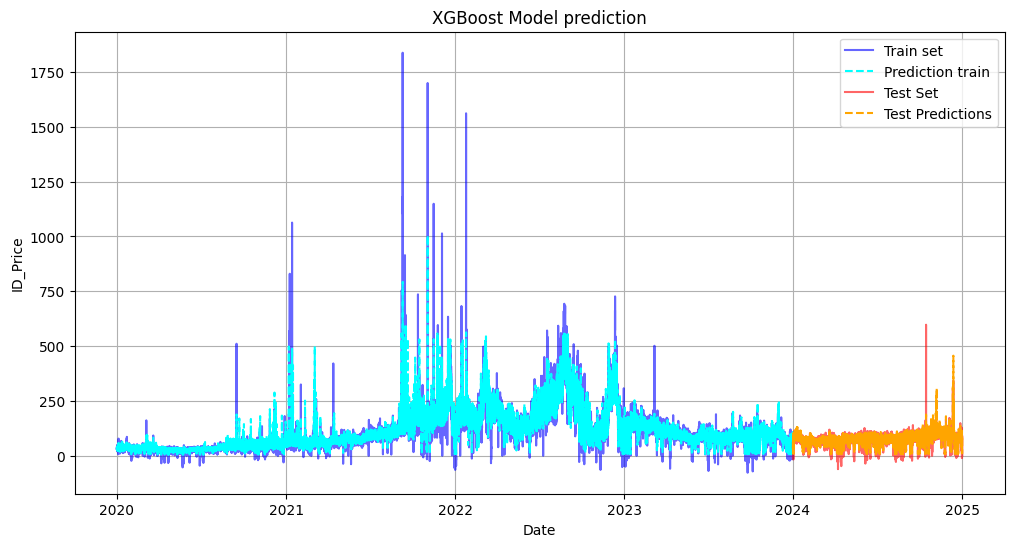

In [108]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

plt.figure(figsize=(12, 6))

plt.plot(train_data.index, y_train, label="Train set", color="blue", alpha=0.6)
plt.plot(train_data.index, train_predictions, label="Prediction train", color="cyan", linestyle="dashed")

plt.plot(test_data.index, y_test, label="Test Set", color="red", alpha=0.6)
plt.plot(test_data.index, test_predictions, label="Test Predictions", color="orange", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("ID_Price")
plt.title("XGBoost Model prediction")
plt.legend()
plt.grid()

plt.show()

Predictions on the training set appear to be generally good but lacks of accuracy on spikes or large fluctuations.

Moreover, predictions on the test set show a generally good trend, but there are more significant differences. This suggests that the model may be sensitive to sudden changes or unexpected events that are not well captured by past trends.

However, we can suggest a possible overfitting

In [77]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Train RMSE  : {train_rmse:.2f}")
print(f"Test RMSE   : {test_rmse:.2f}")

if test_rmse > train_rmse * 1.5:
    print("Potentiel overfitting")

Train RMSE  : 35.56
Test RMSE   : 16.16


In [78]:
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
print("Feature Importance:")
print(importance.sort_values('importance', ascending=False))

Feature Importance:
                   feature  importance
0                 price_DA    0.841089
5                      Day    0.057373
2  TOTAL_MELNGC_ID (in MW)    0.039516
4                    Month    0.029529
1  TOTAL_INDGEN_ID (in MW)    0.015646
3                     Year    0.009773
6                     Hour    0.007074


## B.3.3 SHAP Values

SHAP aims to explain the prediction of an instance by calculating the contribution of each feature to that prediction. Shapley values ​​tell us how to fairly distribute the prediction across features. The equation below demonstrates how the contribution of each feature adds up to form the overall prediction

SHAP values ​​are obtained by a formula that calculates a weighted average of the contribution of each feature over all possible subsets of features. Therefore, SHAP values ​​allow us to assign a unique contribution to each feature. Together, these contributions represent the overall prediction for the observation and are adjusted by the average prediction for all instances.

**Source** : *Lloyd S. Shapley. Notes on the N-Person Game & mdash; II: The Value of an N-Person Game. Santa Monica, CA: RAND Corporation, 1951. doi: 10.7249/RM0670.*

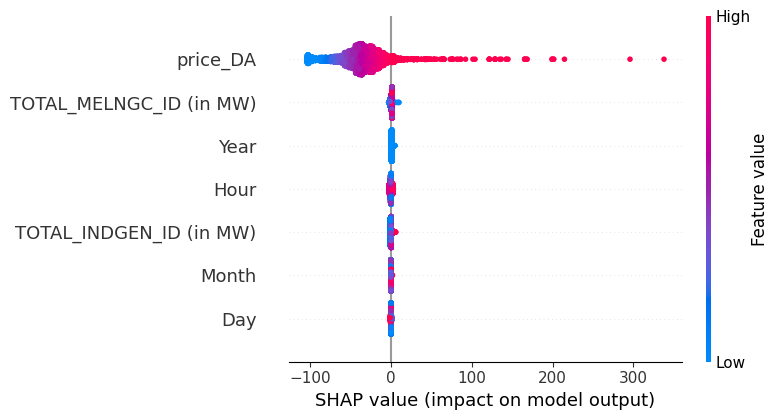

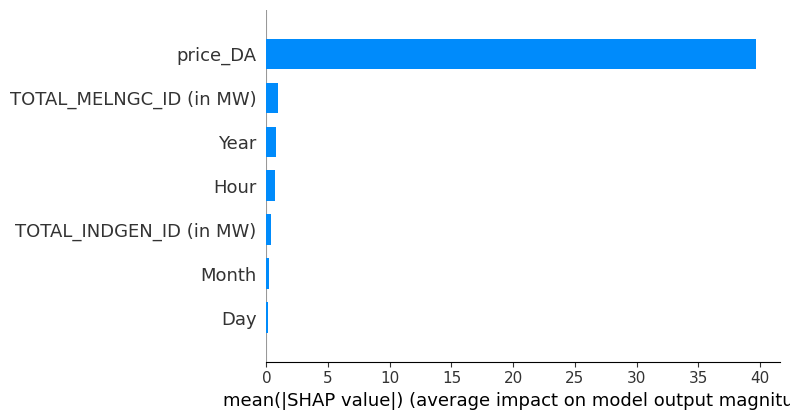

In [79]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

The day-ahead price is by far the most influential variable in the prediction.
The generation variables (TOTAL_MELNGC_ID, TOTAL_INDGEN_ID) have a lesser but noticeable impact.
The temporal variables have a low or very localized influence on the model’s predictions.

